In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

geo = "GSE111803"

In [2]:
data = pd.read_csv("../Dataset/Yao2019/data.txt", sep="\t")

In [3]:
data.columns

Index(['miRNA_ID', 'LC11.readcount', 'LC3.readcount', 'LC4.readcount',
       'LC5.readcount', 'LC6.readcount', 'NC1.readcount', 'NC2.readcount',
       'NC3.readcount', 'NC4.readcount', 'NC5.readcount', 'LC11.tpm',
       'LC3.tpm', 'LC4.tpm', 'LC5.tpm', 'LC6.tpm', 'NC1.tpm', 'NC2.tpm',
       'NC3.tpm', 'NC4.tpm', 'NC5.tpm'],
      dtype='object')

In [4]:
table = data.iloc[:, 1:11].transpose()
mirnas = data.iloc[:, 0]
table

,0,1,2,3,4,5,6,7,8,9,...,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253
LC11.readcount,42,17801,1,3269,0,755,217,3064,1,222,...,0,0,0,0,0,0,0,1,0,0
LC3.readcount,290,85550,31,16998,0,4903,1452,20637,3,1929,...,1,2,6,2,1,1,1,1,0,0
LC4.readcount,186,55582,13,9311,1,2397,604,12929,1,1197,...,0,0,0,0,0,0,0,0,0,0
LC5.readcount,36,11204,6,3983,0,661,227,2185,0,79,...,1,1,0,0,0,0,0,0,0,0
LC6.readcount,93,38312,24,13526,0,1738,575,7146,4,418,...,0,0,3,0,0,0,0,0,0,0
NC1.readcount,44,20829,5,3502,0,606,395,4128,4,520,...,1,0,0,0,1,0,0,0,0,1
NC2.readcount,55,21133,5,3863,0,1156,369,4307,0,244,...,0,0,0,0,2,4,0,0,0,1
NC3.readcount,201,83486,9,10959,0,3195,1220,16604,2,1321,...,3,1,0,0,0,1,0,1,1,0
NC4.readcount,16,7647,3,1723,0,350,105,1238,0,188,...,1,0,0,1,0,0,0,0,0,0
NC5.readcount,152,38915,4,6712,1,2125,739,7739,2,1371,...,2,1,1,0,1,1,0,0,0,0


In [5]:
controls = np.array(["NC" in c for c in table.index])
sick = 1 - controls

### Mean-variance-plot

In [6]:
np.mean(table)

0         111.5
1       38045.9
2          10.1
3        7384.6
4           0.2
         ...   
1249        0.7
1250        0.1
1251        0.3
1252        0.1
1253        0.2
Length: 1254, dtype: float64

In [7]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [8]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

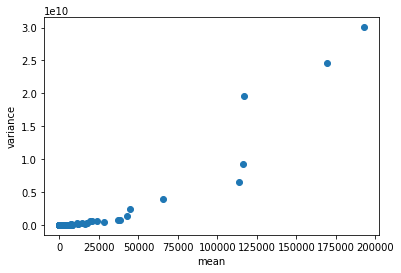

In [9]:
mean_variance_plot(table)

### Log transformation

In [10]:
log_table = table #np.log2(table + 1e-6)

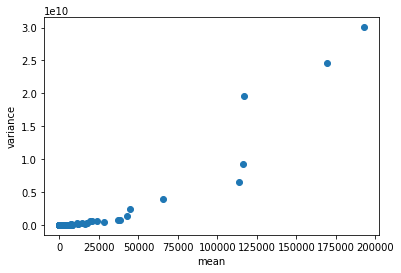

In [11]:
mean_variance_plot(log_table)

### Standardizing

In [12]:
norm_log_table = log_table #- np.mean(log_table)

In [13]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

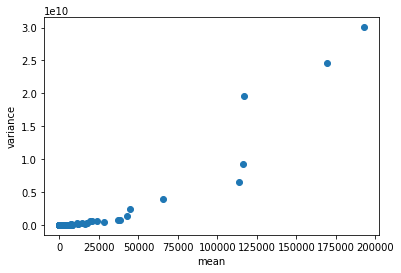

In [14]:
mean_variance_plot(norm_log_table)

In [15]:
norm_log_table.isna().sum().sum()

0

### PCA

In [16]:
pca = decomposition.PCA(n_components=10)

In [17]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [18]:
pca.explained_variance_ratio_

array([8.30977994e-01, 1.51111589e-01, 1.11429609e-02, 3.48984501e-03,
       1.84681135e-03, 8.23607376e-04, 3.91816701e-04, 1.64121913e-04,
       5.12538995e-05, 1.28409733e-32])

In [19]:
components = pca.transform(norm_log_table)

In [20]:
components

array([[-2.28715650e+05,  1.02572616e+04, -8.83751909e+03,
        -1.07651747e+04, -5.87802032e+03, -3.97937770e+03,
        -1.03494934e+04,  7.38819052e+03,  2.17943149e+03,
        -1.33617561e-11],
       [ 5.54018788e+05, -2.16558307e+05,  1.29934339e+04,
        -6.63507935e+03,  3.76889318e+03, -9.91797006e+03,
        -3.69407418e+02, -9.88814169e+01,  5.27046421e+02,
        -2.20147456e-10],
       [ 6.60450736e+04, -3.59203695e+04, -5.98059614e+04,
        -2.50273590e+04,  7.84034664e+03,  1.36192194e+04,
         1.69890419e+02, -5.33591087e+02, -1.83750408e+03,
         1.13054455e-10],
       [-2.54213533e+05,  4.03599177e+03, -1.50768813e+04,
         1.40043158e+03,  9.74925726e+03, -2.76439508e+03,
         1.52625909e+03, -6.76995594e+03,  4.50317992e+03,
         9.67386171e-11],
       [-1.05976310e+05, -1.49880644e+05, -8.44701998e+03,
         3.68915869e+04, -1.72081273e+04,  9.94582666e+03,
         3.90594015e+02,  1.62896552e+02, -2.11821575e+02,
         3.

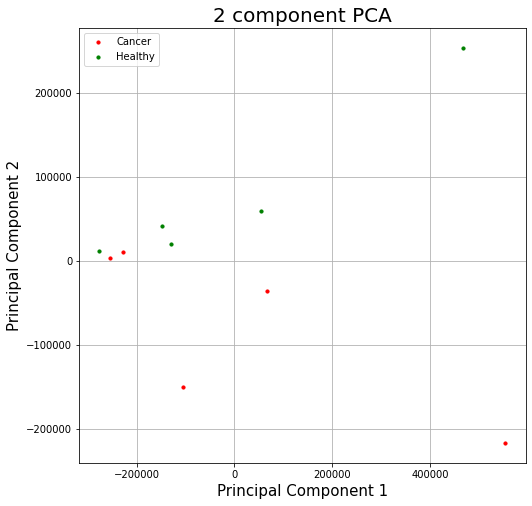

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [22]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

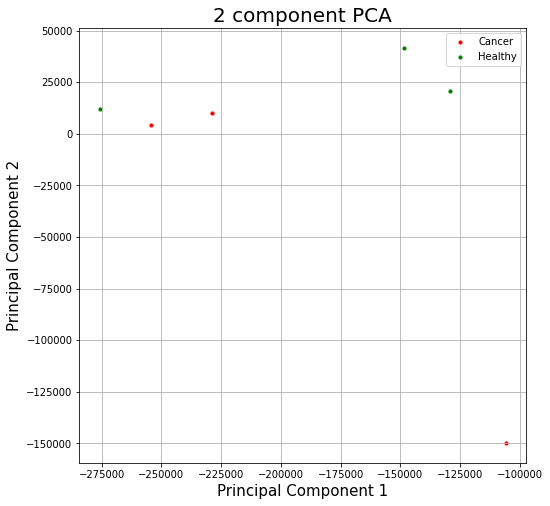

In [23]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [24]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [25]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


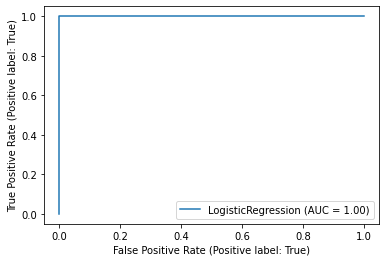

In [26]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [27]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [28]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[20:51:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


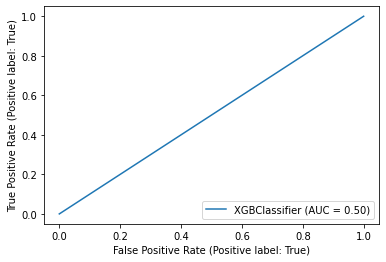

In [29]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [30]:
mirnas[:10]

0    hsa-let-7a-3p
1    hsa-let-7a-5p
2    hsa-let-7b-3p
3    hsa-let-7b-5p
4    hsa-let-7c-3p
5    hsa-let-7c-5p
6    hsa-let-7d-3p
7    hsa-let-7d-5p
8    hsa-let-7e-3p
9    hsa-let-7e-5p
Name: miRNA_ID, dtype: object

In [31]:
from Scripts import converters

In [32]:
sequences = converters.canonical_to_seq(mirnas, True)

In [33]:
sequences = np.array(sequences)

In [34]:
mirnas[sequences == None]

1186    novel_170
1187    novel_179
1188    novel_191
1189    novel_194
1190    novel_210
          ...    
1249    novel_670
1250    novel_672
1251    novel_677
1252    novel_692
1253    novel_699
Name: miRNA_ID, Length: 68, dtype: object

In [35]:
mask = sequences != None
sequences = sequences[mask]
norm_log_table = norm_log_table.loc[:, mask]

In [36]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

C:\Users\olefr\AppData\Local\Temp/ipykernel_23168/3116894495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_log_table["cancer"] = sick


,CUAUACAAUCUACUGUCUUUC,UGAGGUAGUAGGUUGUAUAGUU,CUAUACAACCUACUGCCUUCCC,UGAGGUAGUAGGUUGUGUGGUU,CUGUACAACCUUCUAGCUUUCC,UGAGGUAGUAGGUUGUAUGGUU,CUAUACGACCUGCUGCCUUUCU,AGAGGUAGUAGGUUGCAUAGUU,CUAUACGGCCUCCUAGCUUUCC,UGAGGUAGGAGGUUGUAUAGUU,...,UCUUUGGUUAUCUAGCUGUAUGA,AAUCAUGUGCAGUGCCAAUAUG,UUUGGCACUAGCACAUUUUUGCU,CUAUACAACUUACUACUUUCCC,UGAGGUAGUAAGUUGUAUUGUU,CAAGCUCGCUUCUAUGGGUCUG,AACCCGUAGAUCCGAUCUUGUG,CAAGCUCGUGUCUGUGGGUCCG,CACCCGUAGAACCGACCUUGCG,cancer
LC11.readcount,42,17801,1,3269,0,755,217,3064,1,222,...,26,0,5,1,1313,0,1722,14,473,1
LC3.readcount,290,85550,31,16998,0,4903,1452,20637,3,1929,...,222,0,36,6,5707,0,5913,185,3540,1
LC4.readcount,186,55582,13,9311,1,2397,604,12929,1,1197,...,121,0,32,1,3346,1,1707,69,1507,1
LC5.readcount,36,11204,6,3983,0,661,227,2185,0,79,...,45,0,13,0,954,0,1010,5,271,1
LC6.readcount,93,38312,24,13526,0,1738,575,7146,4,418,...,33,0,57,7,2200,0,1703,64,1268,1


In [37]:
norm_log_table.to_csv("../TransformedData/Yao2019_raw.csv", index=False)